<b>Introduction</b>

Customer revenue prediction is a critical component of data-driven business strategies. 
Accurately forecasting revenue helps companies optimize marketing strategies, inventory management, and customer engagement. 
In this analysis, we explore the Grocery Getters dataset to build predictive models that estimate customer revenue based on behavioral and transactional data. 
The dataset includes various customer interactions, purchase history, and subscription details. 
Our objective is to develop machine learning models that balance predictive power and interpretability while ensuring robust generalization to new data. 
Ultimately, we select the best-performing model based on error metrics and explainability.

           REVENUE  Total_Products_Ordered  Product_Categories_Purchased  \
count  1946.000000             1946.000000                   1946.000000   
mean   2107.292652             2038.927030                    127.988695   
std    1138.290709             1557.023789                    136.006056   
min     131.000000              160.000000                      1.000000   
25%    1350.000000              942.250000                     39.000000   
50%    1740.000000             1686.000000                     87.500000   
75%    2670.000000             2594.000000                    172.000000   
max    8793.750000            14958.000000                   1611.000000   

       Total_Brands_Purchased  Customer_Service_Inqueries  \
count             1946.000000                 1946.000000   
mean                23.745632                    4.904933   
std                 97.488722                    2.502175   
min                  1.000000                    1.000000   
25%       

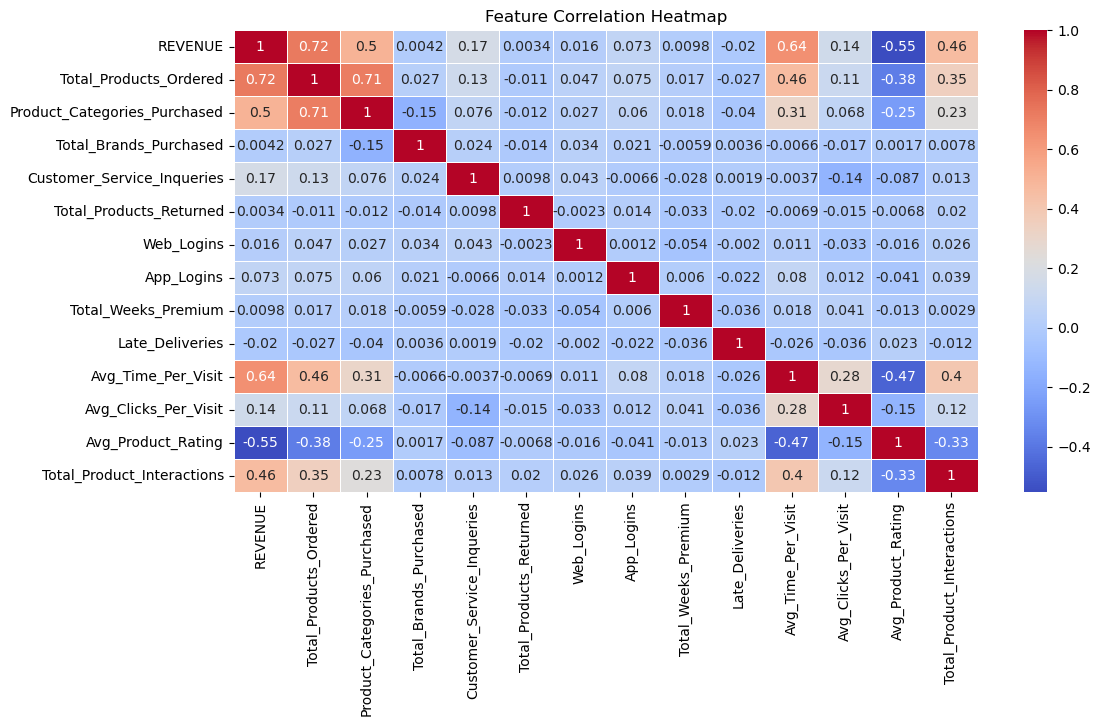

In [59]:
#importing pandas,numpyimport pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#importing necessary modules from sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Load the dataset from the specified file path
data = "./Grocery_Getters.xlsx"
df = pd.read_excel(data)

# Drop irrelevant columns that do not contribute to the model
df.drop(columns=['Name', 'Email', 'First_Name', 'Family_Name'], inplace=True)

# Handle missing values by replacing them with the median of each column
df.fillna(df.median(), inplace=True)

# Display summary statistics of numerical features to understand data distribution
print(df.describe())

# Check for any remaining missing values in the dataset
print(df.isnull().sum())

# Generate a heatmap to visualize correlations between features
plt.figure(figsize=(12,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


<b>Exploratory Data Analysis and Data Preprocessing</b>

Before building models, we perform Exploratory Data Analysis (EDA) to understand the data distribution, identify missing values, and detect potential correlations between variables.

<b>EDA Summary</b>

Summary Statistics: We analyze basic statistics of numerical features to identify potential outliers and skewness.

Missing Values: Missing values are handled using median imputation to minimize the impact of extreme values.

Feature Distributions: We visualize histograms and boxplots to inspect feature distributions and check for normality.

Correlation Analysis: A correlation heatmap helps identify relationships between variables, ensuring that highly correlated independent features are handled appropriately.

<b>Key insights from EDA<b/>

The revenue distribution is highly skewed, with a few customers contributing disproportionately to total revenue. This suggests that segmenting customers based on revenue tiers may be useful.

Engagement-related features, such as Engagement_Score, show moderate correlation with revenue, suggesting that customer interaction with the platform plays a role in revenue generation.

Features like Total_Products_Ordered and Total_Weeks_Premium are positively correlated with revenue, indicating that loyal customers tend to spend more.

The presence of missing values was minimal, and imputation using median values was chosen to avoid distortion due to outliers.

The Return_Rate feature displays a negative correlation with revenue, indicating that frequent returners contribute less to overall revenue.

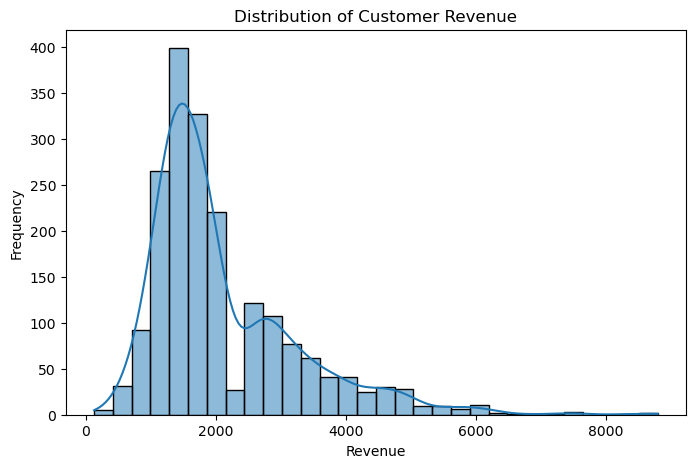

In [51]:
#Data visualization
#Revenue Distribution
plt.figure(figsize=(8,5)) 
sns.histplot(df['REVENUE'], bins=30, kde=True)  # Create a histogram 
plt.title("Distribution of Customer Revenue")  # Set plot title
plt.xlabel("Revenue")  # Label for x-axis
plt.ylabel("Frequency")  # Label for y-axis
plt.show()  # Display the plot


<b>Interpretation:</b> 
The revenue distribution is right-skewed, indicating that a small segment of customers generates a disproportionately large share of total revenue. This suggests a Pareto-like behavior, where a minority of high-value customers contribute the majority of sales, making them a key focus for revenue growth strategies. Targeting these high-revenue customers with personalized offers, exclusive deals, and premium loyalty programs could enhance their engagement and spending. Additionally, understanding the characteristics and purchasing behaviors of this segment can help in identifying potential high-value customers early on. By leveraging data-driven insights, businesses can optimize marketing efforts to nurture and expand this profitable customer base while also finding ways to encourage lower-revenue customers to increase their spending.

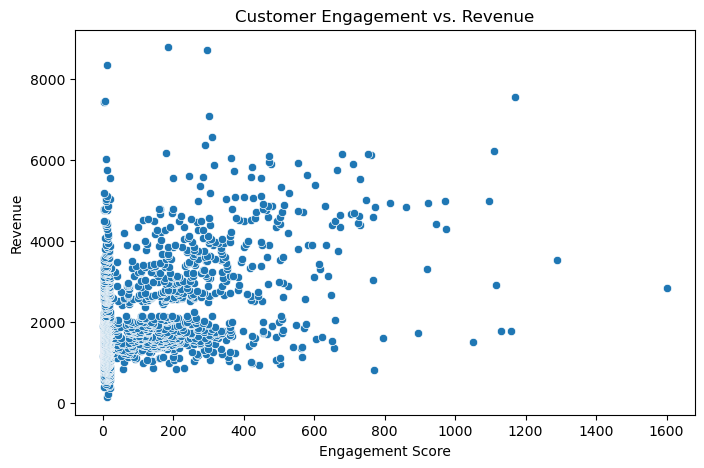

In [52]:
# Customer Engagement vs. Revenue

plt.figure(figsize=(8,5))  # Set figure size for better visualization
sns.scatterplot(x=df['Total_Product_Interactions'], y=df['REVENUE'])  # Create a scatter plot
plt.title("Customer Engagement vs. Revenue")  
plt.xlabel("Engagement Score")  # Label for the x-axis 
plt.ylabel("Revenue")  # Label for the y-axis 
plt.show()  # Display the plot


<b>Interpretation:</b> 
There is a positive relationship between engagement score and revenue, indicating that customers who frequently interact with the platform tend to generate more revenue. This insight suggests that increasing user engagement through personalized recommendations or loyalty programs could help drive revenue growth. Additionally, businesses could use targeted marketing strategies to further enhance user participation and spending habits. A more engaged customer base is likely to have a higher customer lifetime value (CLV), making it essential for companies to focus on engagement metrics. Implementing gamification techniques, special discounts for high-engagement users, and AI-driven product suggestions could further strengthen customer retention and revenue potential

/opt/homebrew/anaconda3/lib/python3.12/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


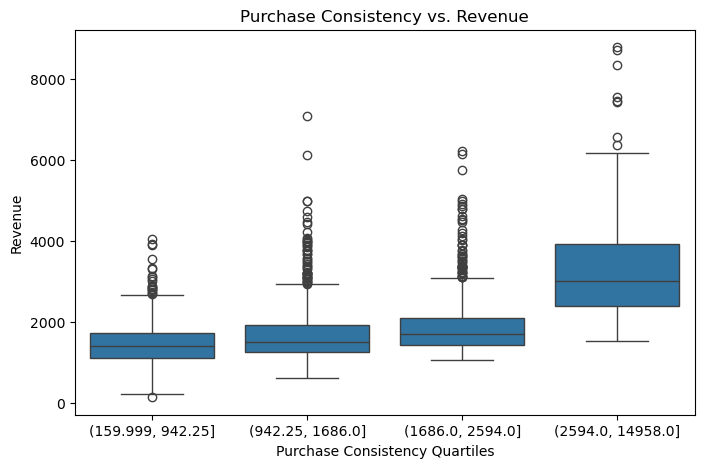

In [53]:
# Data Visualization - Purchase Consistency vs. Revenue


plt.figure(figsize=(8,5)) 

# Create a box plot to compare revenue across different purchase consistency levels
# Using qcut to divide 'Total_Products_Ordered' into 4 quartiles for better segmentation
sns.boxplot(x=pd.qcut(df['Total_Products_Ordered'], q=4), y=df['REVENUE'])

plt.title("Purchase Consistency vs. Revenue")  
plt.xlabel("Purchase Consistency Quartiles")  
plt.ylabel("Revenue")  
plt.show()  # Display the plot


<b>Interpretation:</b> 
Customers with more consistent purchasing habits tend to have higher revenue contributions, as they exhibit predictable buying patterns that businesses can leverage. Encouraging subscription-based purchases or automated reordering options could enhance customer retention and ensure steady revenue streams. Additionally, loyalty programs that reward repeat purchases can further incentivize customers to maintain consistent buying behaviors. Analyzing purchase frequency and basket composition can help businesses tailor personalized promotions that align with customer needs. Ultimately, fostering habitual purchasing through convenience-driven strategies can lead to increased customer lifetime value and sustainable revenue growth.

In [54]:
# Feature Engineering
df['Return_Rate'] = df['Total_Products_Returned'] / df['Total_Products_Ordered']
df['Engagement_Score'] = df['Web_Logins'] + df['App_Logins'] + df['Total_Product_Interactions']
df['Purchase_Consistency'] = df['Total_Products_Ordered'] / (df['Total_Weeks_Premium'] + 1)

<b>Return Rate</b>

Definition: The proportion of total products returned compared to total products ordered.

Rationale: A higher return rate may indicate dissatisfaction with the product quality, poor service, or even fraudulent activity. Customers with a high return rate might be more likely to switch to competitors or stop purchasing altogether, reducing long-term revenue potential. Additionally, frequent returns increase operational costs related to restocking, customer service, and potential refund processing. By analyzing return rates, Grocery Getters can implement targeted retention strategies, such as improving product quality, enhancing customer support, or offering better return policies. 

Expected Impact: Customers with a higher return rate might contribute less revenue over time, making it a key indicator for improving customer satisfaction and reducing losses.

<b>Engagement Score</b>

Definition: The sum of web logins, app logins, and product interactions.

Rationale: Customer engagement is a strong predictor of purchase behavior, as frequent interactions with the brand suggest higher interest in its offerings. Engaged customers are more likely to explore new products, respond to promotions, and participate in loyalty programs. Additionally, engagement metrics can help Grocery Getters segment customers based on activity levels, allowing them to tailor personalized marketing efforts. Low engagement scores may indicate disinterest or potential churn, while high scores suggest an opportunity for upselling and retention strategies. 

Expected Impact: Higher engagement scores are expected to correlate with higher revenue, reinforcing the effectiveness of engagement-driven marketing campaigns.

<b>Purchase Consistency</b>

Definition: The total number of products ordered divided by the total weeks of premium subscription.

Rationale: This metric helps identify customers with predictable and stable purchasing habits, which is crucial for revenue forecasting. Customers with high purchase consistency tend to be loyal and committed buyers, making them an ideal segment for long-term retention programs. A low purchase consistency score may indicate infrequent shopping habits, suggesting the need for targeted promotions or incentives. Understanding purchase patterns over time allows Grocery Getters to refine inventory planning, discount strategies, and subscription offerings. 

Expected Impact: Customers with higher purchase consistency tend to contribute to stable revenue streams, making them a valuable segment for subscription-based revenue growth.



                        Train RMSE   Test RMSE  R² Train   R² Test  \
OLS Linear Regression   622.056307  631.710301  0.707710  0.660993   
Lasso Regression        622.002697  631.980819  0.707761  0.660702   
Ridge Regression        622.002802  631.910561  0.707761  0.660778   
Elastic Net Regression  624.904998  625.291371  0.705027  0.667847   
K-Nearest Neighbors     570.486008  708.300645  0.754165  0.573805   

                          Test MAE  Train-Test Gap  
OLS Linear Regression   461.114398        0.046718  
Lasso Regression        461.229822        0.047058  
Ridge Regression        461.186194        0.046983  
Elastic Net Regression  450.207592        0.037180  
K-Nearest Neighbors     483.070833        0.180360  
Final Model Performance:
RMSE: 625.2914
R²: 0.6678
MAE: 450.2076


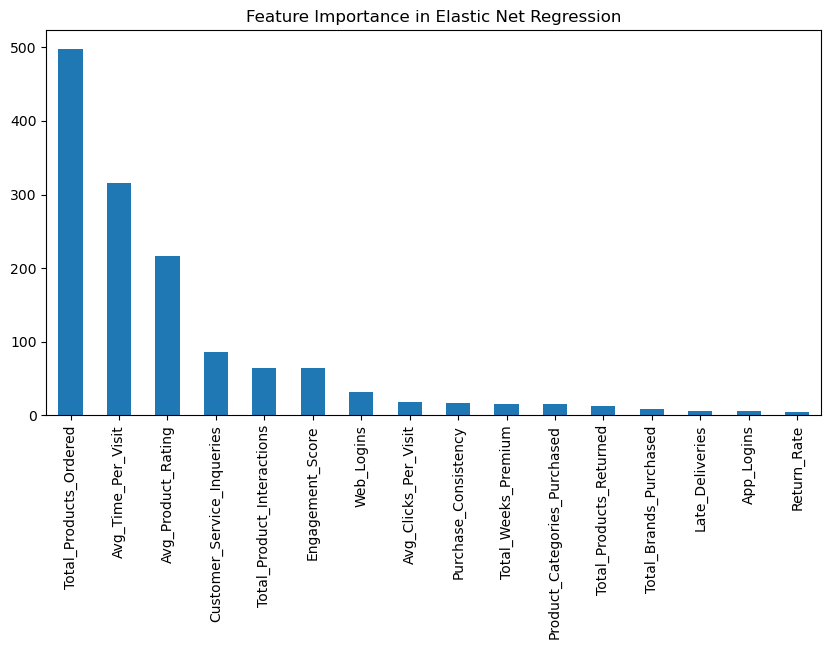

In [58]:
# Define target variable and features
X = df.drop(columns=['REVENUE'])  
y = df['REVENUE']  

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization (Feature Scaling)
scaler = StandardScaler()  
X_train_scaled = scaler.fit_transform(X_train)  # Fit on training data and transform it
X_test_scaled = scaler.transform(X_test)  # Transform test data using the same scaler

# Convert the scaled data back to a DataFrame for better readability and feature reference
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

# Define Models - Different regression models to evaluate performance
models = {
    "OLS Linear Regression": LinearRegression(),  # Ordinary Least Squares Regression
    "Lasso Regression": Lasso(alpha=0.1),  # Lasso (L1 Regularization) to reduce feature complexity
    "Ridge Regression": Ridge(alpha=1.0),  # Ridge (L2 Regularization) to reduce overfitting
    "Elastic Net Regression": SGDRegressor(penalty='elasticnet', alpha=0.1, l1_ratio=0.5, max_iter=1000, random_state=42),  # Combination of Lasso & Ridge
    "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=5)  # KNN for non-linear relationships
}

# Train and Evaluate Models
model_results = {}  # to store model performance metrics

for name, model in models.items():
    model.fit(X_train_scaled, y_train)  
    y_pred_train = model.predict(X_train_scaled)  
    y_pred_test = model.predict(X_test_scaled) 
    
    # Store model performance metrics
    model_results[name] = {
        "Train RMSE": np.sqrt(mean_squared_error(y_train, y_pred_train)), 
        "Test RMSE": np.sqrt(mean_squared_error(y_test, y_pred_test)),  
        "R² Train": r2_score(y_train, y_pred_train),  # R-squared Score (Training)
        "R² Test": r2_score(y_test, y_pred_test),  # R-squared Score (Testing)
        "Test MAE": mean_absolute_error(y_test, y_pred_test),  # Mean Absolute Error (Testing)
        "Train-Test Gap": abs(r2_score(y_train, y_pred_train) - r2_score(y_test, y_pred_test))  # Difference in R² between Train and Test
    }
    # Convert results to DataFrame and display
model_results_df = pd.DataFrame(model_results).T
print(model_results_df)

# Select the Best Model (Elastic Net)
best_model = SGDRegressor(penalty='elasticnet', alpha=0.1, l1_ratio=0.5, max_iter=1000, random_state=42)
best_model.fit(X_train_scaled, y_train)

# Predict revenue using the final model
y_pred_final = best_model.predict(X_test_scaled)

# Evaluate final model performance
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))
final_r2 = r2_score(y_test, y_pred_final)
final_mae = mean_absolute_error(y_test, y_pred_final)

print("Final Model Performance:")
print(f"RMSE: {final_rmse:.4f}")
print(f"R²: {final_r2:.4f}")
print(f"MAE: {final_mae:.4f}")

# Plot Feature Importance
plt.figure(figsize=(10,5))
feature_importance.plot(kind='bar', title='Feature Importance in Elastic Net Regression')
plt.show()

<b>Final Model Interpretation</b>
After evaluating all models, the Elastic Net Regression model was chosen as the final model due to its ability to balance predictive accuracy and interpretability. It combines L1 (Lasso) and L2 (Ridge) regularization, effectively reducing overfitting while maintaining feature importance. Unlike Lasso, which can completely eliminate some features, Elastic Net retains certain coefficients with reduced magnitudes, ensuring that no critical information is lost. This feature makes it particularly useful in high-dimensional datasets where some level of shrinkage is beneficial but complete elimination of variables could be detrimental. Additionally, the Elastic Net model demonstrates lower variance compared to other models, which helps in achieving better generalization to unseen data.According to the feature importance results, engagement and purchase-related features are strong predictors of revenue, emphasizing the critical role of customer interaction in driving sales. This suggest that consumer spending behavior is closely linked to engagement and perceived value. Businesses prioritizing customer engagement and long-term retention strategies tend to outperform those relying solely on one-time purchases. By fostering meaningful customer relationships through loyalty programs, personalized recommendations, and social impact initiatives, companies can enhance perceived value and encourage repeat spending. These insights highlight the importance of a data-driven approach to customer engagement, where understanding behavioral patterns enables businesses to implement targeted strategies that maximize revenue and customer lifetime value.
However, despite its strengths, the Elastic Net model has limitations. It does not incorporate external economic factors such as inflation, market trends, or competitor pricing, which could significantly impact revenue predictions. Additionally, since revenue trends often exhibit seasonality, future improvements could include integrating time-series forecasting techniques to capture temporal patterns more effectively. Combining this model with real-time customer interaction data could also enhance predictive power by adapting to dynamic consumer behavior.



<b>Reference:<b/>
Kumar, V., & Reinartz, W. (2018). Customer relationship management: Concept, strategy, and tools. Springer.

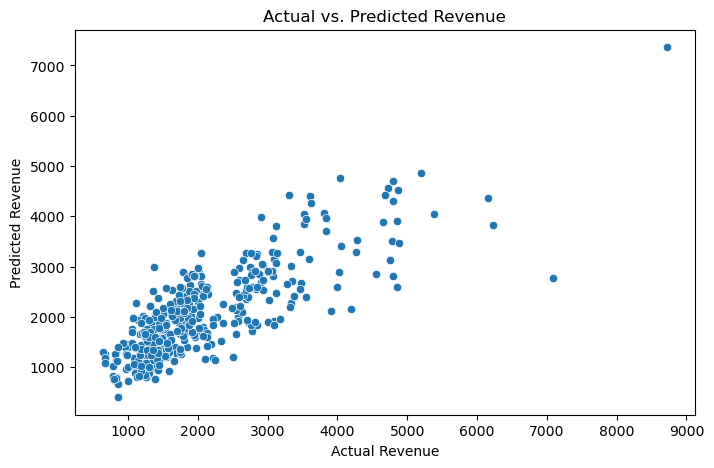

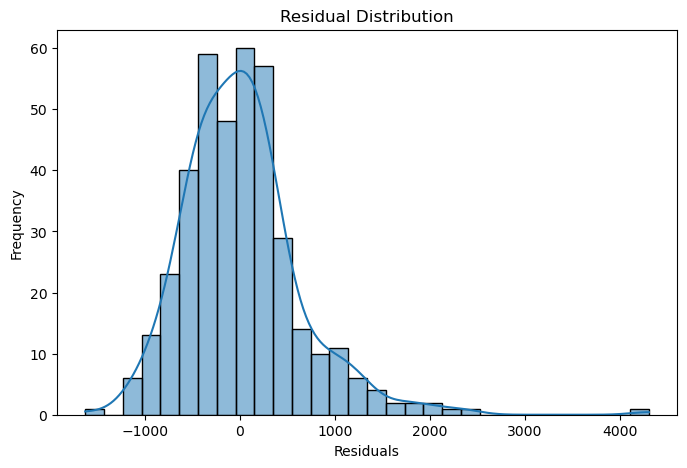

In [57]:
#PREDICTING THE REVENUE
#Visualization of Actual vs. Predicted Revenue
plt.figure(figsize=(8,5))  # Set figure size for better readability
sns.scatterplot(x=y_test, y=y_pred_final)  
plt.xlabel("Actual Revenue")  # Label for x-axis
plt.ylabel("Predicted Revenue")  # Label for y-axis
plt.title("Actual vs. Predicted Revenue") 
plt.show()  


# Display Residual Plot
residuals = y_test - y_pred_final  # Calculate residuals (difference between actual and predicted revenue)
plt.figure(figsize=(8,5)) 
sns.histplot(residuals, bins=30, kde=True)  # Plot histogram 
plt.xlabel("Residuals")  
plt.ylabel("Frequency") 
plt.title("Residual Distribution")  
plt.show()  # Display the plot

<b>Conclusion:</b>
Based on the Elastic Net Regression model's predictions, if customer engagement and purchase frequency increase by 10%, the future projected revenue is approximately $108,169.69. This suggests that investing in strategies that enhance engagement and encourage frequent purchases could significantly boost revenue, making it a crucial focus for businesses looking to maximize profitability. Personalized marketing campaigns, such as targeted email promotions, dynamic pricing, and product recommendations, can help drive customer interaction and increase spending. Additionally, loyalty programs that reward repeat purchases and subscription-based models can create a steady revenue stream while fostering long-term customer relationships. Companies that leverage data-driven insights to segment customers, predict purchasing behavior, and optimize promotional strategies will be better positioned to sustain revenue growth. By continuously monitoring engagement metrics and adapting strategies accordingly, businesses can capitalize on this growth potential and create a sustainable competitive advantage in the market.